This script offers a preliminary evaluation of a variant of the motif graph learning algorithm that considers the observations follow a GMRF whose precision matrix is given by a polynomial of the GSO.

In [11]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

from sklearn.covariance import graphical_lasso
import src.utils as utils
import spectral_nti as snti

SEED = 0
N_CPUS = cpu_count()
np.random.seed(SEED)

PATH = './results/gmrf_st/'

## Auxiliary functions

In [12]:
def est_graph(id, models, MM, L, K, iters, verb=False):
    X = utils.create_GMRF_st_signals(L, K, MM[-1])

    N = X.shape[0]
    A_hat = np.zeros((N, N, len(models), len(MM)))
    lamd_hat = np.zeros((N, len(models), len(MM)))
    for i, M in enumerate(MM):
        C_hat = X[:,:M]@X[:,:M].T/M

        # Individual standard constraints
        for j, model in enumerate(models):
            t = time.time()

            if model['name'] == 'GLasso':
                try:
                    _, L_hat = graphical_lasso(C_hat, model['alpha'], max_iter=iters)
                except FloatingPointError:
                    L_hat = np.zeros((N,N))
            elif model['St']:
                L_hat, _ = snti.MGL_Stationary_GMRF(C_hat, model['gs'], model['bounds'], 
                                                    model['cs'], model['regs'], max_iters=iters,
                                                    verbose=verb, epsilon=1e-5)
            else:
                L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], 
                                    model['cs'], model['regs'], max_iters=iters,
                                    verbose=verb, epsilon=1e-5)

            lamd_hat[:,j,i], _ = np.linalg.eigh(L_hat) 
            A_hat[:,:,j,i] = np.diag(np.diag(L_hat)) - L_hat
            t = time.time() - t
            print('Cov-{}, M-{}: Model: {}-{} - Time(sec): {:.3}'.format(id, M, model['name'],  model['St'], t))
    return A_hat, lamd_hat


def est_errs(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):
                if np.all((A_hat[:,:,j,i,k] == 0)):
                    norm_A_hat = 1
                    norm_lam_hat = 1
                else:
                    norm_A_hat = np.linalg.norm(A_hat[:,:,j,i,k], 'fro')
                    norm_lam_hat = np.linalg.norm(lams_hat[:,j,i,k], 2)

                A_hat_norm = A_hat[:,:,j,i,k]/norm_A_hat
                lam_hat_norm = lams_hat[:,j,i,k]/norm_lam_hat
                err_A[j,i,k] = np.linalg.norm(A/norm_A-A_hat_norm,'fro')
                err_lamb[j,i,k] = np.linalg.norm(lamd/norm_lam-lam_hat_norm, 2)

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def est_errs2(A, lamd, A_hat, lams_hat, sq_err=True):
    norm_A = np.linalg.norm(A, 'fro')
    norm_lam = np.linalg.norm(lamd, 2)

    err_lamb = np.zeros(lams_hat.shape[1:])
    err_A = np.zeros(A_hat.shape[2:])
    for k in range(A_hat.shape[-1]):
        for i in range(A_hat.shape[-2]):
            for j in range(A_hat.shape[-3]):

                err_A[j,i,k] = np.linalg.norm(A-A_hat[:,:,j,i,k],'fro')/norm_A
                err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam

                if sq_err:
                    err_A[j,i,k] = err_A[j,i,k]**2
                    err_lamb[j,i,k] = err_lamb[j,i,k]**2

    return err_A, err_lamb


def plot_err(MM, models, err, ylab, semlogy=True, ylim=[]):
    plt.figure()
    for i, model in enumerate(models):
        if semlogy:
            plt.semilogy(MM, err[i,:], model['fmt'], label=model['name'],
                        linewidth=2, markersize=12)
        else:
            plt.plot(MM, err[i,:], model['fmt'], label=model['name'],
                     linewidth=2, markersize=12)
        plt.grid(True)
        plt.xlabel('Number of samples')
        plt.ylabel(ylab)
        plt.legend()
        plt.xlim([MM[0], MM[-1]])
        if ylim:
            plt.ylim(ylim)
        plt.tight_layout()


def print_err(MM, models, err):
    mean_err = np.mean(err, 2)
    std = np.std(err, 2)
    for i, M in enumerate(MM):
        print('M:', M)
        for j, model in enumerate(models):
            print('\t{}: mean err: {:.6f} - std: {:.6f}'.
                   format(model['name'], mean_err[j,i], std[j,i]))

## Create graphs

Norm of A: 11.489125293076057
Norm of lambdas: 32.03123475609394


Text(0.5, 1.0, 'True Lambdas, N: 20')

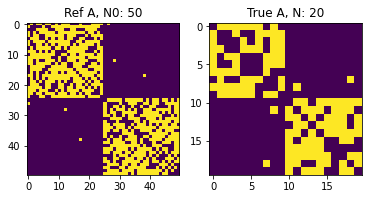

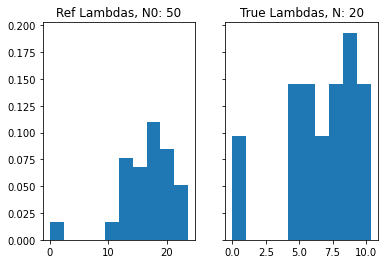

In [13]:
# G params
p = .7
q = .01
block_sizes0 = [25, 25]
block_sizes = [10, 10]

# Ref graph
A0 = nx.to_numpy_array(nx.random_partition_graph(block_sizes0, p, q))
L0 = np.diag(np.sum(A0, 0)) - A0
lambdas0, _ = np.linalg.eigh(L0)
N0 = lambdas0.shape[0]

# Target graph

A = nx.to_numpy_array(nx.random_partition_graph(block_sizes, p, q))
L = np.diag(np.sum(A, 0)) - A
lambdas, V = np.linalg.eigh(L)
N = lambdas.shape[0]

norm_A = np.linalg.norm(A,'fro')
norm_lamb = np.linalg.norm(lambdas)

print('Norm of A:', norm_A)
print('Norm of lambdas:', norm_lamb)

# Plot graphs and spectrum distribution
plt.figure()
plt.subplot(1,2,1)
plt.imshow(A0)
plt.title('Ref A, N0: ' + str(N0))
plt.subplot(1,2,2)
plt.imshow(A)
plt.title('True A, N: ' + str(N))
    
figs, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist(lambdas0, density=True)
axs[0].set_title('Ref Lambdas, N0: ' + str(N0))
axs[1].hist(lambdas, density=True)
axs[1].set_title('True Lambdas, N: ' + str(N))

In [14]:
plt.rcParams['figure.facecolor'] = 'white'

## Compare contraints

In [15]:
n_covs = 10  #100
#MM = np.arange(300, 1501, 100)
MM = [100, 150, 200, 250, 300, 350, 400]
K = 4
iters = 30 # 50

GS = [
    lambda a, b : cp.sum(a)/b,
    lambda a, b : cp.sum(a**2)/b,
    lambda a, b : cp.sum(cp.exp(-a))/b,
    lambda a, b : cp.sum(cp.sqrt(a))/b,
    lambda a, b : cp.sum((.5*a-.75)**2)/b,
]
BOUNDS = [
    lambda lamd, lamd_t, b : -2/b*lamd_t.T@lamd,
    lambda lamd, lamd_t, b : 1/b*cp.exp(-lamd_t).T@lamd,
    lambda lamd, lamd_t, b : cp.sum(lamd/cp.sqrt(lamd_t))/(2*b),
    lambda lamd, lamd_t, b: 1/b*(0.75-.5*lamd_t).T@lamd,
]

# deltas = [.04, .27, .003, .02, 0.05]
deltas = [11, 257, .07, 1.9, 56]
cs, err_cs = utils.compute_cs(GS, lambdas0, lambdas, verbose=True)

models = [
    {'St': False, 'name': 'GLasso', 'alpha': 0.05, 'fmt': '^:'},

   
    {'St': True, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 1, 'eta': 1, 'inc_eta': 1.1,
              'deltas': deltas[0]}},

    {'St': True, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o-',
     'regs': {'alpha': .0, 'beta': 1.5, 'gamma': 500, 'eta': .05, 'inc_eta': 1.1,
              'deltas': deltas[1]}},

    {'St': True, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's-',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 10, 'eta': .1, 'inc_eta': 1.1, 
              'deltas': deltas[4]}},

    # Non-st

    {'St': False, 'name': 'Tr', 'gs': GS[0], 'bounds': [], 'cs': cs[0], 'fmt': '2--',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 1, 'deltas': deltas[0]}},

    {'St': False, 'name': 'Sq', 'gs': GS[1], 'bounds': BOUNDS[0], 'cs': cs[1], 'fmt': 'o--',
     'regs': {'alpha': .0, 'beta': 1.5, 'gamma': 500, 'deltas': deltas[1]}},

    {'St': False, 'name': 'BR', 'gs': GS[4], 'bounds': BOUNDS[3], 'cs': cs[4], 'fmt': 's--',
     'regs': {'alpha': 0, 'beta': 1.5, 'gamma': 10, 'deltas': deltas[4]}},
]

	c-0: c: 6.600	c0: 16.520	err: -9.920000	err norm: -0.600484
	c-1: c: 51.300	c0: 294.080	err: -242.780000	err norm: -0.825558
	c-2: c: 0.039	c0: 0.016	err: 0.022552	err norm: 1.399431
	c-3: c: 2.442	c0: 3.973	err: -1.531197	err norm: -0.385397
	c-4: c: 8.409	c0: 61.681	err: -53.271875	err norm: -0.863664


In [16]:
# Estimate graph
verbose = False

total_t = time.time()
As_hat = np.zeros((N, N, len(models), len(MM), n_covs))
lamds_hat = np.zeros((N, len(models), len(MM), n_covs)) 

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(est_graph)(i, models, MM, L, K, iters, verbose) for i in range(n_covs))
for i, resp in enumerate(resps):
    As_hat[:,:,:,:,i], lamds_hat[:,:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 64


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010793637435005388, tolerance: 3.1549622340219125e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015856017916110465, tolerance: 3.189210304877421e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.65879219200549e-05, tolerance: 2.976020026040851e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

Cov-8, M-100: Model: GLasso-False - Time(sec): 0.0132
Cov-6, M-100: Model: GLasso-False - Time(sec): 0.0264
Cov-1, M-100: Model: GLasso-False - Time(sec): 0.0133
Cov-5, M-100: Model: GLasso-False - Time(sec): 0.0286
Cov-9, M-100: Model: GLasso-False - Time(sec): 0.0474
Cov-0, M-100: Model: GLasso-False - Time(sec): 0.0501
Cov-7, M-100: Model: GLasso-False - Time(sec): 0.0538
Cov-2, M-100: Model: GLasso-False - Time(sec): 0.0521
Cov-3, M-100: Model: GLasso-False - Time(sec): 0.0536
Cov-4, M-100: Model: GLasso-False - Time(sec): 0.0603


/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/srey/.local/lib/python3.8/site-packages/cvxpy/prob

CONVERGENCE AT ITERATION: 8
Cov-5, M-100: Model: Tr-True - Time(sec): 12.0
CONVERGENCE AT ITERATION: 19
Cov-1, M-100: Model: Tr-True - Time(sec): 24.7
CONVERGENCE AT ITERATION: 9
Cov-6, M-100: Model: Tr-True - Time(sec): 27.8
Cov-8, M-100: Model: Tr-True - Time(sec): 28.6
CONVERGENCE AT ITERATION: 1
Cov-8, M-100: Model: Sq-True - Time(sec): 3.97
Cov-7, M-100: Model: Tr-True - Time(sec): 34.9
Cov-4, M-100: Model: Tr-True - Time(sec): 35.4
Cov-0, M-100: Model: Tr-True - Time(sec): 35.4
Cov-3, M-100: Model: Tr-True - Time(sec): 35.4
Cov-9, M-100: Model: Tr-True - Time(sec): 36.8
CONVERGENCE AT ITERATION: 1
Cov-3, M-100: Model: Sq-True - Time(sec): 2.8
CONVERGENCE AT ITERATION: 1
Cov-0, M-100: Model: Sq-True - Time(sec): 3.08
Cov-2, M-100: Model: Tr-True - Time(sec): 38.6
CONVERGENCE AT ITERATION: 1
Cov-2, M-100: Model: Sq-True - Time(sec): 2.57
Cov-5, M-100: Model: Sq-True - Time(sec): 31.3
Cov-7, M-100: Model: Sq-True - Time(sec): 22.3
Cov-8, M-100: Model: BR-True - Time(sec): 26.3
Cov-8

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00225412610197262, tolerance: 0.0002756979258318642
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064733020939997665, tolerance: 0.0002753678220400061
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007788969086307107, tolerance: 0.00026798236128223606
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklea

Cov-3, M-100: Model: BR-True - Time(sec): 23.9
Cov-3, M-100: Model: Tr-False - Time(sec): 0.218
Cov-3, M-100: Model: Sq-False - Time(sec): 0.248
Cov-3, M-100: Model: BR-False - Time(sec): 0.26
Cov-3, M-200: Model: GLasso-False - Time(sec): 0.00757


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004593137264657099, tolerance: 3.4547205247705055e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001691586083570895, tolerance: 3.376513819140584e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010775011588134986, tolerance: 3.385109254019597e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

Cov-0, M-100: Model: BR-True - Time(sec): 24.8
Cov-0, M-100: Model: Tr-False - Time(sec): 0.217
Cov-0, M-100: Model: Sq-False - Time(sec): 0.245
Cov-4, M-100: Model: Sq-True - Time(sec): 28.5
Cov-0, M-100: Model: BR-False - Time(sec): 0.251
Cov-0, M-200: Model: GLasso-False - Time(sec): 0.032


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004318960185755727, tolerance: 2.265082019944555e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.203667374055864e-05, tolerance: 2.1313707526263818e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.731561670378524e-05, tolerance: 2.159118047819818e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

Cov-1, M-100: Model: Sq-True - Time(sec): 41.3
CONVERGENCE AT ITERATION: 25
Cov-5, M-100: Model: BR-True - Time(sec): 23.5
Cov-5, M-100: Model: Tr-False - Time(sec): 0.218
Cov-5, M-100: Model: Sq-False - Time(sec): 0.246
Cov-5, M-100: Model: BR-False - Time(sec): 0.252
Cov-5, M-200: Model: GLasso-False - Time(sec): 0.0169


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010392574729738147, tolerance: 1.3189423660362138e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.934139404705497e-05, tolerance: 1.2350121017057675e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013462200637431865, tolerance: 7.210170925798257e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-9, M-100: Model: Sq-True - Time(sec): 31.4
Cov-6, M-100: Model: Sq-True - Time(sec): 41.2
Cov-2, M-100: Model: BR-True - Time(sec): 29.8
Cov-2, M-100: Model: Tr-False - Time(sec): 0.266
Cov-2, M-100: Model: Sq-False - Time(sec): 0.259
Cov-2, M-100: Model: BR-False - Time(sec): 0.292
Cov-2, M-200: Model: GLasso-False - Time(sec): 0.0326


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040145819714303144, tolerance: 2.7583285712339092e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.50999756150206e-05, tolerance: 2.7535587800658207e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.661962364249099e-05, tolerance: 2.691596089122492e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 1
Cov-8, M-200: Model: Tr-True - Time(sec): 13.6
Cov-7, M-100: Model: BR-True - Time(sec): 18.1
Cov-7, M-100: Model: Tr-False - Time(sec): 0.225
Cov-7, M-100: Model: Sq-False - Time(sec): 0.281
Cov-7, M-100: Model: BR-False - Time(sec): 0.264
Cov-7, M-200: Model: GLasso-False - Time(sec): 0.0326


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005321976839695874, tolerance: 4.4778498378892806e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.814211177077033e-05, tolerance: 4.250992786476879e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.6919932018145714e-05, tolerance: 4.575240141409817e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 1
Cov-8, M-200: Model: Sq-True - Time(sec): 6.23
CONVERGENCE AT ITERATION: 8
Cov-5, M-200: Model: Tr-True - Time(sec): 18.9
CONVERGENCE AT ITERATION: 8
Cov-2, M-200: Model: Tr-True - Time(sec): 17.0
Cov-4, M-100: Model: BR-True - Time(sec): 27.1
Cov-4, M-100: Model: Tr-False - Time(sec): 0.215
Cov-4, M-100: Model: Sq-False - Time(sec): 0.242
Cov-4, M-100: Model: BR-False - Time(sec): 0.25
Cov-4, M-200: Model: GLasso-False - Time(sec): 0.0509


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005634770002956202, tolerance: 0.0026984370616482166
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004810737375581908, tolerance: 0.0026926612530771762
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005252877526476851, tolerance: 0.0027775851701748325
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklear

CONVERGENCE AT ITERATION: 1
Cov-5, M-200: Model: Sq-True - Time(sec): 5.96
CONVERGENCE AT ITERATION: 1
Cov-2, M-200: Model: Sq-True - Time(sec): 4.53
Cov-9, M-100: Model: BR-True - Time(sec): 32.9
Cov-9, M-100: Model: Tr-False - Time(sec): 0.218
Cov-9, M-100: Model: Sq-False - Time(sec): 0.247
Cov-9, M-100: Model: BR-False - Time(sec): 0.254
Cov-9, M-200: Model: GLasso-False - Time(sec): 0.032


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00024252136454275264, tolerance: 3.854162370460691e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013418746207405352, tolerance: 3.87305801128588e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001517164729062659, tolerance: 3.6392656784924196e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

Cov-6, M-100: Model: BR-True - Time(sec): 33.1
Cov-6, M-100: Model: Tr-False - Time(sec): 0.223
Cov-6, M-100: Model: Sq-False - Time(sec): 0.246
Cov-6, M-100: Model: BR-False - Time(sec): 0.262
Cov-6, M-200: Model: GLasso-False - Time(sec): 0.0313
CONVERGENCE AT ITERATION: 6
Cov-2, M-200: Model: BR-True - Time(sec): 9.45


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035250359773658646, tolerance: 2.4175912097660286e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00011308638146052125, tolerance: 2.4345532629213797e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.0618877211389135e-05, tolerance: 2.377135024209714e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

Cov-2, M-200: Model: Tr-False - Time(sec): 0.218
Cov-2, M-200: Model: Sq-False - Time(sec): 0.246
Cov-2, M-200: Model: BR-False - Time(sec): 0.253
Cov-2, M-300: Model: GLasso-False - Time(sec): 0.00442


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032667020029242266, tolerance: 2.956734732566535e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.137589750135117e-05, tolerance: 2.778270557783711e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001327668175992447, tolerance: 2.9768026448616003e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 10
Cov-7, M-200: Model: Tr-True - Time(sec): 29.8
CONVERGENCE AT ITERATION: 15
Cov-5, M-200: Model: BR-True - Time(sec): 14.7
Cov-5, M-200: Model: Tr-False - Time(sec): 0.217
Cov-5, M-200: Model: Sq-False - Time(sec): 0.246
Cov-5, M-200: Model: BR-False - Time(sec): 0.252
Cov-5, M-300: Model: GLasso-False - Time(sec): 0.0199


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002311638797433263, tolerance: 1.3438213687070877e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5309370184295812e-05, tolerance: 1.2272726688134572e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001484535076941365, tolerance: 7.98367795180371e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/s

CONVERGENCE AT ITERATION: 19
Cov-0, M-200: Model: Tr-True - Time(sec): 48.7
CONVERGENCE AT ITERATION: 8
Cov-3, M-200: Model: Tr-True - Time(sec): 50.5
Cov-8, M-200: Model: BR-True - Time(sec): 35.8
Cov-8, M-200: Model: Tr-False - Time(sec): 0.218
Cov-8, M-200: Model: Sq-False - Time(sec): 0.255
Cov-8, M-200: Model: BR-False - Time(sec): 0.281
Cov-8, M-300: Model: GLasso-False - Time(sec): 0.00651


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018809231023682038, tolerance: 0.00025591461513759103
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006203216310071591, tolerance: 0.0002543368896056072
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006595204380011044, tolerance: 0.0002503935038767971
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

CONVERGENCE AT ITERATION: 1
Cov-0, M-200: Model: Sq-True - Time(sec): 3.76
CONVERGENCE AT ITERATION: 1
Cov-3, M-200: Model: Sq-True - Time(sec): 3.4
CONVERGENCE AT ITERATION: 16
Cov-7, M-200: Model: Sq-True - Time(sec): 11.5
CONVERGENCE AT ITERATION: 8
Cov-5, M-300: Model: Tr-True - Time(sec): 15.3
CONVERGENCE AT ITERATION: 14
Cov-7, M-200: Model: BR-True - Time(sec): 8.23
Cov-7, M-200: Model: Tr-False - Time(sec): 0.241
Cov-7, M-200: Model: Sq-False - Time(sec): 0.246
Cov-7, M-200: Model: BR-False - Time(sec): 0.252
Cov-7, M-300: Model: GLasso-False - Time(sec): 0.00454


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037985703230786205, tolerance: 4.552587402816152e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.501138940443908e-05, tolerance: 4.57407154835999e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.700103155509509e-05, tolerance: 4.61341850489058e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

CONVERGENCE AT ITERATION: 6
Cov-3, M-200: Model: BR-True - Time(sec): 10.0
Cov-3, M-200: Model: Tr-False - Time(sec): 0.251
Cov-3, M-200: Model: Sq-False - Time(sec): 0.281
Cov-3, M-200: Model: BR-False - Time(sec): 0.298
Cov-3, M-300: Model: GLasso-False - Time(sec): 0.0329


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004151677754091754, tolerance: 3.500763936265705e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00015710855340766994, tolerance: 3.375033652725805e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014688711232530016, tolerance: 3.51113542136846e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 11
Cov-0, M-200: Model: BR-True - Time(sec): 13.8
Cov-0, M-200: Model: Tr-False - Time(sec): 0.217
Cov-0, M-200: Model: Sq-False - Time(sec): 0.246
Cov-0, M-200: Model: BR-False - Time(sec): 0.252
Cov-0, M-300: Model: GLasso-False - Time(sec): 0.0319


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048822826862994495, tolerance: 2.3879978407135234e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.791543503223031e-05, tolerance: 2.323697002470267e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.885977271603225e-05, tolerance: 2.3044934121521584e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

Cov-4, M-200: Model: Tr-True - Time(sec): 41.8
CONVERGENCE AT ITERATION: 9
Cov-9, M-200: Model: Tr-True - Time(sec): 32.5
CONVERGENCE AT ITERATION: 1
Cov-9, M-200: Model: Sq-True - Time(sec): 2.55
CONVERGENCE AT ITERATION: 9
Cov-6, M-200: Model: Tr-True - Time(sec): 36.6
CONVERGENCE AT ITERATION: 22
Cov-5, M-300: Model: Sq-True - Time(sec): 16.8
Cov-1, M-100: Model: BR-True - Time(sec): 76.2
Cov-1, M-100: Model: Tr-False - Time(sec): 0.218
Cov-1, M-100: Model: Sq-False - Time(sec): 0.249
Cov-1, M-100: Model: BR-False - Time(sec): 0.256
Cov-1, M-200: Model: GLasso-False - Time(sec): 0.0323


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035079378657620897, tolerance: 3.1463542597441966e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001355338731122424, tolerance: 3.1660693687644726e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.191271664828356e-05, tolerance: 3.082429900521721e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 5
Cov-5, M-300: Model: BR-True - Time(sec): 4.23
Cov-5, M-300: Model: Tr-False - Time(sec): 0.218
Cov-5, M-300: Model: Sq-False - Time(sec): 0.246
Cov-5, M-300: Model: BR-False - Time(sec): 0.252
Cov-5, M-400: Model: GLasso-False - Time(sec): 0.015
CONVERGENCE AT ITERATION: 6
Cov-9, M-200: Model: BR-True - Time(sec): 7.91


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00020917176003615312, tolerance: 1.1666072228699184e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1274668962663395e-05, tolerance: 1.0716077654999847e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.863089012250622e-05, tolerance: 8.105345966918384e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages

Cov-9, M-200: Model: Tr-False - Time(sec): 0.226
Cov-9, M-200: Model: Sq-False - Time(sec): 0.247
Cov-9, M-200: Model: BR-False - Time(sec): 0.277
Cov-9, M-300: Model: GLasso-False - Time(sec): 0.0319


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002300391543920699, tolerance: 3.415135197130482e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.657621242291746e-05, tolerance: 3.3950840135516594e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.478620303758623e-05, tolerance: 3.283486613438866e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 1
Cov-6, M-200: Model: Sq-True - Time(sec): 11.5
CONVERGENCE AT ITERATION: 9
Cov-8, M-300: Model: Tr-True - Time(sec): 38.6
CONVERGENCE AT ITERATION: 8
Cov-2, M-300: Model: Tr-True - Time(sec): 53.2
CONVERGENCE AT ITERATION: 10
Cov-7, M-300: Model: Tr-True - Time(sec): 32.0
CONVERGENCE AT ITERATION: 1
Cov-2, M-300: Model: Sq-True - Time(sec): 1.85
CONVERGENCE AT ITERATION: 1
Cov-8, M-300: Model: Sq-True - Time(sec): 5.39
CONVERGENCE AT ITERATION: 2
Cov-6, M-200: Model: BR-True - Time(sec): 10.0
Cov-6, M-200: Model: Tr-False - Time(sec): 0.212
Cov-6, M-200: Model: Sq-False - Time(sec): 0.249
Cov-6, M-200: Model: BR-False - Time(sec): 0.25
Cov-6, M-300: Model: GLasso-False - Time(sec): 0.0054


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003432689598275168, tolerance: 2.1397181870574917e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.205265832853827e-05, tolerance: 2.1033783229744482e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.43019241855927e-05, tolerance: 2.118962021012583e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 3
Cov-2, M-300: Model: BR-True - Time(sec): 3.91
Cov-4, M-200: Model: Sq-True - Time(sec): 29.1
Cov-2, M-300: Model: Tr-False - Time(sec): 0.216
Cov-2, M-300: Model: Sq-False - Time(sec): 0.269
Cov-2, M-300: Model: BR-False - Time(sec): 0.252
Cov-2, M-400: Model: GLasso-False - Time(sec): 0.00545


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023690035144184607, tolerance: 2.5943655233706254e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.476174089457219e-05, tolerance: 2.5406408995458137e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.095169388120215e-05, tolerance: 2.649757656367046e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 10
Cov-0, M-300: Model: Tr-True - Time(sec): 34.6
CONVERGENCE AT ITERATION: 8
Cov-3, M-300: Model: Tr-True - Time(sec): 39.7
CONVERGENCE AT ITERATION: 1
Cov-0, M-300: Model: Sq-True - Time(sec): 3.11
CONVERGENCE AT ITERATION: 1
Cov-3, M-300: Model: Sq-True - Time(sec): 1.93
CONVERGENCE AT ITERATION: 8
Cov-5, M-400: Model: Tr-True - Time(sec): 26.1
CONVERGENCE AT ITERATION: 2
Cov-8, M-300: Model: BR-True - Time(sec): 13.6
Cov-8, M-300: Model: Tr-False - Time(sec): 0.241
Cov-8, M-300: Model: Sq-False - Time(sec): 0.261
Cov-8, M-300: Model: BR-False - Time(sec): 0.259
Cov-8, M-400: Model: GLasso-False - Time(sec): 0.00691


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013663898931350893, tolerance: 0.0002174135889981669
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004880181200108247, tolerance: 0.00021438244610465836
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00543695762197105, tolerance: 0.00021052197567060233
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

CONVERGENCE AT ITERATION: 5
Cov-3, M-300: Model: BR-True - Time(sec): 5.51
Cov-3, M-300: Model: Tr-False - Time(sec): 0.225
Cov-3, M-300: Model: Sq-False - Time(sec): 0.302
Cov-3, M-300: Model: BR-False - Time(sec): 0.264
Cov-3, M-400: Model: GLasso-False - Time(sec): 0.00758
CONVERGENCE AT ITERATION: 4
Cov-0, M-300: Model: BR-True - Time(sec): 7.08


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004024947745172869, tolerance: 3.28527638514865e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003093954611464722, tolerance: 3.166210448993025e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.660930802784073e-05, tolerance: 3.320946211903999e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/skle

Cov-0, M-300: Model: Tr-False - Time(sec): 0.239
Cov-0, M-300: Model: Sq-False - Time(sec): 0.243
Cov-0, M-300: Model: BR-False - Time(sec): 0.25
Cov-0, M-400: Model: GLasso-False - Time(sec): 0.0321
CONVERGENCE AT ITERATION: 8
Cov-1, M-200: Model: Tr-True - Time(sec): 33.8


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006159742986902722, tolerance: 2.651311536396314e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018538500592299445, tolerance: 2.6246930780736034e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.448721308801529e-05, tolerance: 2.7078241304628938e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

Cov-7, M-300: Model: Sq-True - Time(sec): 19.5
CONVERGENCE AT ITERATION: 3
Cov-7, M-300: Model: BR-True - Time(sec): 3.52
Cov-7, M-300: Model: Tr-False - Time(sec): 0.215
Cov-7, M-300: Model: Sq-False - Time(sec): 0.244
Cov-7, M-300: Model: BR-False - Time(sec): 0.249
Cov-7, M-400: Model: GLasso-False - Time(sec): 0.00561


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003363258157000615, tolerance: 4.124217875060952e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.849419297505488e-05, tolerance: 4.067263441941306e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.281134449405811e-05, tolerance: 4.1562613728723197e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

Cov-4, M-200: Model: BR-True - Time(sec): 26.9
Cov-4, M-200: Model: Tr-False - Time(sec): 0.214
Cov-4, M-200: Model: Sq-False - Time(sec): 0.243
Cov-4, M-200: Model: BR-False - Time(sec): 0.247
Cov-4, M-300: Model: GLasso-False - Time(sec): 0.0469


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004219906569627341, tolerance: 0.0032567349329204135
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005377280649323524, tolerance: 0.0032314839956794714
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007749409667308527, tolerance: 0.00328630858770224
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/

CONVERGENCE AT ITERATION: 9
Cov-6, M-300: Model: Tr-True - Time(sec): 30.6
Cov-5, M-400: Model: Sq-True - Time(sec): 22.7
CONVERGENCE AT ITERATION: 15
Cov-1, M-200: Model: Sq-True - Time(sec): 17.0
CONVERGENCE AT ITERATION: 3
Cov-5, M-400: Model: BR-True - Time(sec): 3.09
Cov-5, M-400: Model: Tr-False - Time(sec): 0.216
Cov-5, M-400: Model: Sq-False - Time(sec): 0.243
Cov-5, M-400: Model: BR-False - Time(sec): 0.249
CONVERGENCE AT ITERATION: 3
Cov-1, M-200: Model: BR-True - Time(sec): 5.93
Cov-1, M-200: Model: Tr-False - Time(sec): 0.215
Cov-1, M-200: Model: Sq-False - Time(sec): 0.244
Cov-1, M-200: Model: BR-False - Time(sec): 0.25
Cov-1, M-300: Model: GLasso-False - Time(sec): 0.032


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00019329018980394908, tolerance: 2.835159060898147e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.53826003291741e-05, tolerance: 2.8725450689500887e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9524891236312216e-05, tolerance: 2.7593884412829808e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 9
Cov-9, M-300: Model: Tr-True - Time(sec): 56.6
CONVERGENCE AT ITERATION: 1
Cov-9, M-300: Model: Sq-True - Time(sec): 3.28
CONVERGENCE AT ITERATION: 9
Cov-3, M-400: Model: Tr-True - Time(sec): 31.8
CONVERGENCE AT ITERATION: 11
Cov-0, M-400: Model: Tr-True - Time(sec): 34.1
CONVERGENCE AT ITERATION: 5
Cov-9, M-300: Model: BR-True - Time(sec): 8.3
Cov-9, M-300: Model: Tr-False - Time(sec): 0.214
Cov-9, M-300: Model: Sq-False - Time(sec): 0.242
Cov-9, M-300: Model: BR-False - Time(sec): 0.248
Cov-9, M-400: Model: GLasso-False - Time(sec): 0.0316


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002637296918714116, tolerance: 3.141727167475992e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.664835324426965e-05, tolerance: 3.0720622206007675e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.206479449867187e-05, tolerance: 3.066500326100923e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sk

CONVERGENCE AT ITERATION: 1
Cov-0, M-400: Model: Sq-True - Time(sec): 4.39
CONVERGENCE AT ITERATION: 10
Cov-2, M-400: Model: Tr-True - Time(sec): 53.3
CONVERGENCE AT ITERATION: 1
Cov-2, M-400: Model: Sq-True - Time(sec): 3.83
CONVERGENCE AT ITERATION: 7
Cov-4, M-300: Model: Tr-True - Time(sec): 31.7
CONVERGENCE AT ITERATION: 2
Cov-0, M-400: Model: BR-True - Time(sec): 7.58
Cov-0, M-400: Model: Tr-False - Time(sec): 0.216
Cov-0, M-400: Model: Sq-False - Time(sec): 0.242
Cov-0, M-400: Model: BR-False - Time(sec): 0.25
CONVERGENCE AT ITERATION: 9
Cov-8, M-400: Model: Tr-True - Time(sec): 52.8
CONVERGENCE AT ITERATION: 17
Cov-7, M-400: Model: Tr-True - Time(sec): 45.5
CONVERGENCE AT ITERATION: 2
Cov-2, M-400: Model: BR-True - Time(sec): 7.62
Cov-2, M-400: Model: Tr-False - Time(sec): 0.216
Cov-2, M-400: Model: Sq-False - Time(sec): 0.243
Cov-2, M-400: Model: BR-False - Time(sec): 0.25
CONVERGENCE AT ITERATION: 1
Cov-8, M-400: Model: Sq-True - Time(sec): 3.79
Cov-6, M-300: Model: Sq-True - 

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003299524602349002, tolerance: 2.2333849971486838e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.818337272791741e-05, tolerance: 2.162620259312576e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9443748763901285e-05, tolerance: 2.2371904529897004e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/

CONVERGENCE AT ITERATION: 2
Cov-3, M-400: Model: BR-True - Time(sec): 6.94
Cov-3, M-400: Model: Tr-False - Time(sec): 0.216
CONVERGENCE AT ITERATION: 6
Cov-8, M-400: Model: BR-True - Time(sec): 18.1
Cov-3, M-400: Model: Sq-False - Time(sec): 0.244
Cov-8, M-400: Model: Tr-False - Time(sec): 0.213
Cov-3, M-400: Model: BR-False - Time(sec): 0.251
Cov-8, M-400: Model: Sq-False - Time(sec): 0.24
Cov-8, M-400: Model: BR-False - Time(sec): 0.248
Cov-4, M-300: Model: Sq-True - Time(sec): 31.2
CONVERGENCE AT ITERATION: 2
Cov-7, M-400: Model: BR-True - Time(sec): 11.0
Cov-7, M-400: Model: Tr-False - Time(sec): 0.213
Cov-7, M-400: Model: Sq-False - Time(sec): 0.24
Cov-7, M-400: Model: BR-False - Time(sec): 0.266
CONVERGENCE AT ITERATION: 9
Cov-9, M-400: Model: Tr-True - Time(sec): 50.2
Cov-1, M-300: Model: Tr-True - Time(sec): 65.1
CONVERGENCE AT ITERATION: 1
Cov-9, M-400: Model: Sq-True - Time(sec): 3.47
CONVERGENCE AT ITERATION: 1
Cov-1, M-300: Model: Sq-True - Time(sec): 3.1
CONVERGENCE AT ITE

/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00030854950376518753, tolerance: 3.0550042182550845e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001677483324345891, tolerance: 3.0455394674005522e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8858857116234065e-05, tolerance: 3.0541047650515584e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-package

CONVERGENCE AT ITERATION: 21
Cov-4, M-300: Model: BR-True - Time(sec): 30.5
Cov-4, M-300: Model: Tr-False - Time(sec): 0.211
Cov-4, M-300: Model: Sq-False - Time(sec): 0.26
Cov-4, M-300: Model: BR-False - Time(sec): 0.244
Cov-4, M-400: Model: GLasso-False - Time(sec): 0.0461


/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004949989987551362, tolerance: 0.0029486855284910993
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030280769407973196, tolerance: 0.002929054660464725
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:244: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005085003371306129, tolerance: 0.0029400677806637383
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/home/srey/anaconda3/lib/python3.8/site-packages/sklear

CONVERGENCE AT ITERATION: 16
Cov-9, M-400: Model: BR-True - Time(sec): 18.5
Cov-9, M-400: Model: Tr-False - Time(sec): 0.211
Cov-9, M-400: Model: Sq-False - Time(sec): 0.239
Cov-9, M-400: Model: BR-False - Time(sec): 0.245
CONVERGENCE AT ITERATION: 8
Cov-6, M-400: Model: Tr-True - Time(sec): 43.1
CONVERGENCE AT ITERATION: 1
Cov-6, M-400: Model: Sq-True - Time(sec): 9.27
CONVERGENCE AT ITERATION: 9
Cov-4, M-400: Model: Tr-True - Time(sec): 17.9
CONVERGENCE AT ITERATION: 8
Cov-1, M-400: Model: Tr-True - Time(sec): 27.7
CONVERGENCE AT ITERATION: 14
Cov-6, M-400: Model: BR-True - Time(sec): 13.5
Cov-6, M-400: Model: Tr-False - Time(sec): 0.209
Cov-6, M-400: Model: Sq-False - Time(sec): 0.236
Cov-6, M-400: Model: BR-False - Time(sec): 0.243
CONVERGENCE AT ITERATION: 1
Cov-1, M-400: Model: Sq-True - Time(sec): 3.3
CONVERGENCE AT ITERATION: 2
Cov-1, M-400: Model: BR-True - Time(sec): 5.66
Cov-1, M-400: Model: Tr-False - Time(sec): 0.21
Cov-1, M-400: Model: Sq-False - Time(sec): 0.237
Cov-1, M

/tmp/ipykernel_4140496/1628647518.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


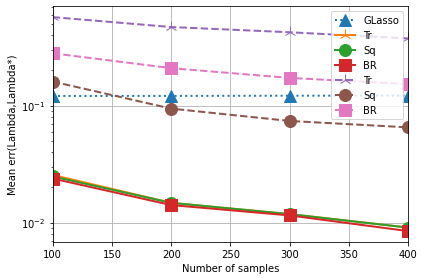

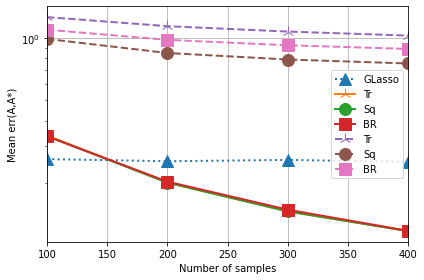

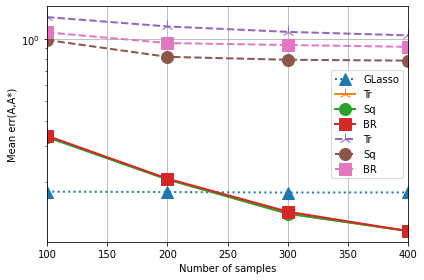

In [17]:
err_A, err_lamd = est_errs(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A.png')



/tmp/ipykernel_4140496/1628647518.py:74: RuntimeWarning: divide by zero encountered in divide
  err_lamb[j,i,k] = np.linalg.norm(lamd/-lams_hat[:,j,i,k], 2)/norm_lam
/tmp/ipykernel_4140496/1628647518.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


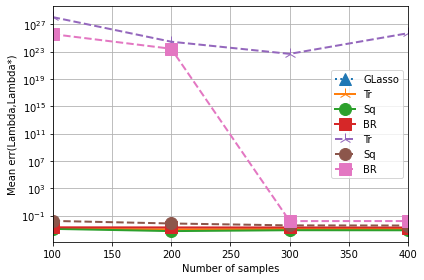

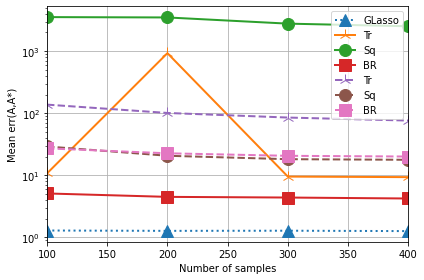

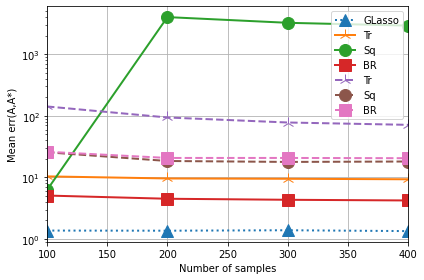

In [18]:
err_A, err_lamd = est_errs2(A, lambdas, As_hat, lamds_hat, sq_err=True)

mean_err_lam = np.mean(err_lamd, 2)
plot_err(MM, models, mean_err_lam, 'Mean err(Lambda,Lambda*)')
plt.savefig('tmp/err_lamb2.png')

mean_err_A = np.mean(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A2.png')

mean_err_A = np.median(err_A, 2)
plot_err(MM, models, mean_err_A, 'Mean err(A,A*)')
plt.savefig('tmp/err_A_med2.png')

In [19]:
# Save np data
models_aux = [{'name': model['name'], 'St': model['St'], 'fmt': model['fmt']}
                for model in models]
data = {
    'A': A,
    'lambdas': lambdas,
    'lambdas0': lambdas0,
    'As_hat': As_hat,
    'lamds_hat': lamds_hat,
    'MM': MM,
    'models': models_aux
}
file = 'st_SBM_{}covs_{}iters'.format(n_covs, iters)
np.save(PATH + file, data)

In [20]:
# Save data as csv
# fname = PATH + 'constraints.csv'
# utils.error_to_csv(fname, models, MM, mean_err_lam)


In [21]:
# %matplotlib qt

# # Load data
# file = 'results/constraints/constraints_100covs_200iters.npy'
# data = np.load(file, allow_pickle=True).item()
# models = data['models']

# A = data['A']
# lambdas = data['lambdas']
# lambdas0 = data['lambdas0']
# As_hat = data['As_hat']
# lamds_hat = data['lamds_hat']
# MM = data['MM']
# models = data['models']